# MODELO PREDICTIVO - SUBS - LA RUTA DEL DINERO

# 1. Preprocesamiento de datos

In [26]:
# 1. Importar librerías
import time
ini = time.time()
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import bokeh as bk
import warnings
warnings.filterwarnings('ignore')

# 2. Cargar la data
Tablon_subs = pd.read_csv('Tablon_sub.csv')
# Dar formato a las columnas
Tablon_subs.columns = Tablon_subs.columns.str.split('.').str[1] +'|' + np.arange(Tablon_subs.columns.size).astype(np.str)
# Selección de variables 
Tablon_subs1 = Tablon_subs[['ruc|0','num_entid_invol|23','num_pais_origen|24', 'num_pais_destino|25', 
                            'prop_transac_nac|26','prop_transac_int|27', 'prom_transacxent|28', 'fob|33','rango_usd_inf|34', 'rango_usd_sup|35', 
                            'marca_clase|36','diferencia|37', 'proporcion|38', 'num_vinculados|64', 'num_vinculos|65',
                            'num_trabajadores|66', 'num_socios|67', 'representantes|68']]
Tablon_subs1.columns = Tablon_subs1.columns.str.split('|').str[0]

# Data reto anterior
data_modelar_diego = pd.read_csv('input_modelar_Diego.csv')
data_modelar_diego['mepeco'] = np.where(data_modelar_diego.pricos_mepecos == 'MEPECO', 1,0)
data_modelar_diego['prico'] = np.where(data_modelar_diego.pricos_mepecos == 'PRICO', 1,0)
variables1 = np.array(['ruc','mepeco', 'prico', 'ventas_Prom', 'compras_Prom', 'ratio_igvcred_igvdeb_prom', 
                       'I_M_compras', 'I_M_ventas'])
data_modelar_diego = data_modelar_diego[variables1]

data_cluster_diego = pd.read_csv('input_cluster_Diego.csv')
data_cluster_diego = pd.concat([pd.DataFrame(data_cluster_diego['ruc']), data_cluster_diego.iloc[:,0:1]], axis = 1)
#data_cluster_diego['ruc'] = data_cluster_diego['ruc'].astype(np.int64)
Data_ant = data_modelar_diego.merge(data_cluster_diego, on='ruc', how = 'left')
Data_ant = Data_ant.sort_values('ruc')
Data_ant1 = Data_ant.drop_duplicates()

Data_rcc = pd.read_excel('data_rcc_final.xlsx')
Data_rcc1 = Data_rcc

# Variables de ITF
Data_itf = pd.read_csv('var_mp_itf.csv')
Data_itf.columns = Data_itf.columns.str.split('.').str[1]
Data_itf1 = Data_itf[['ruc', 'numero_operaciones_internacionales','monto_base_itf_internac', 
                      'numero_operaciones_otros', 'monto_base_itf_otros',
                     'numero_operaciones_7', 'monto_base_itf_7']]

print(Tablon_subs1.shape, 'Tablón subvaluadores')
print(Data_ant1.shape, 'Data modelo anterior')
print(Data_rcc1.shape, 'Data de RCC')
print(Data_itf1.shape, 'Data de ITF')


# Unir dataframes
dfs = [Tablon_subs1, Data_ant1, Data_rcc1,Data_itf1]
from functools import reduce
dataset = reduce(lambda left,right: pd.merge(left,right,on='ruc', how = 'left'), dfs)
dataset = dataset.sort_values('ruc')
dataset = dataset.drop_duplicates('ruc')


# Variables para la target
target = dataset[['ruc','fob',
       'rango_usd_inf', 'rango_usd_sup', 'marca_clase', 'diferencia',
       'proporcion']]

# Calcular la proporción para la target
target['target'] = np.absolute((target.fob/target.rango_usd_inf)-1)*100

# categorizar la target
target['target'] =np.where(target.proporcion<20,0,
                           np.where(target.proporcion.between(20,50, inclusive = False),1,
                                    np.where(target.proporcion.between(51,80, inclusive = False),2,0)))
target = target[['ruc', 'target']]

# Variables Predictoras
v_independientes = dataset[['ruc', 'num_entid_invol', 'num_pais_origen', 'num_pais_destino','prop_transac_nac', 
                            'prop_transac_int', 'prom_transacxent', 'num_vinculados', 'num_vinculos', 'num_trabajadores',
                            'num_socios', 'representantes', 'mepeco', 'prico', 'ventas_Prom','compras_Prom',
                            'ratio_igvcred_igvdeb_prom', 'I_M_compras','I_M_ventas', 'Préstamos', 
                            'Tarjetas de crédito','meses_act', 'Pignoraticios', 'Sobregiros en cuenta corriente',
                            'Avances en cuenta corriente', 'Arrendamiento financiero','Créditos- Comercio exterior',
                            'Otros créditos', 'Factoring', 'Lease - back', 'numero_operaciones_internacionales',
                            'monto_base_itf_internac', 'numero_operaciones_otros',
                            'monto_base_itf_otros', 'numero_operaciones_7', 'monto_base_itf_7']]
# Crear tablón final
dataset_final = v_independientes.merge(target, on='ruc',how = 'left')
# Guardar tablon en excel
#dataset_final.to_excel('dataset_sub_final.xlsx', index=False)
print(dataset_final.shape, 'Dataset final')

fin = time.time()
print('El proceso ha tardado: ', (fin-ini)/60, 'minutos')

(1443, 18) Tablón subvaluadores
(47911, 9) Data modelo anterior
(33171, 12) Data de RCC
(1439, 7) Data de ITF
(1443, 37) Dataset final
El proceso ha tardado:  0.07740333477656046 minutos


# 2. Análisis exploratorio

In [27]:
ini = time.time()
# Leer la data
dataset = pd.read_excel('dataset_sub_final.xlsx')
# Distribución de la target
print('La distribución de la target es: \n',pd.value_counts(dataset.target), '\n')
# Valores nulos
nulos = pd.DataFrame(dataset.isnull().sum()/dataset.shape[0]*100, columns=['na'])
print('El porcentaje de nulos para cada variable es: \n', nulos[nulos.na>0], '\n')
# Cantidad de ceros
ceros = pd.DataFrame(((dataset.iloc[:,0:dataset.shape[1]-1] == 0).sum()/dataset.shape[0]*100), columns=['ceros'])
fil1_columns = ceros[ceros.ceros>30]
print('El porcentaje de ceros por variables es: \n',fil1_columns, '\n')

# Selección de variables
dataset1 = dataset[['ruc', 'num_entid_invol', 'num_pais_origen', 'num_pais_destino',
       'prop_transac_nac', 'prop_transac_int', 'prom_transacxent',
       'num_vinculados', 'num_vinculos', 'num_trabajadores', 'num_socios',
       'representantes', 'Préstamos', 'Tarjetas de crédito', 'meses_act',
       'Sobregiros en cuenta corriente', 'numero_operaciones_internacionales',
       'monto_base_itf_internac', 'numero_operaciones_otros',
       'monto_base_itf_otros', 'mepeco','prico', 'target']]

# Cantidad de ceros en el dataset1
ceros1 = pd.DataFrame(((dataset1 == 0).sum()/dataset1.shape[0]*100), columns=['ceros'])
print('El porcentaje de ceros en el dataset 1 es: \n', ceros1[ceros1.ceros>30])
print('Todas las variables tienen menos de 30% de ceros, estas tres son categoricas \n')

# Valores nulos en el dataset1
nulos1 = pd.DataFrame(dataset1.isnull().sum()/dataset1.shape[0]*100, columns=['na'])
print('Las variables con valores nulos en el dataset1 son: \n', nulos1[nulos1.na>0], '\n')

# Reemplazar valores perdidos por la mediana
dataset2 = dataset1.fillna(dataset.median())

# Verificación de valores nulos después de la imputación
nulos1 = pd.DataFrame(dataset2.isnull().sum()/dataset2.shape[0]*100, columns=['na'])
print('Las variables con valores nulos, después de la imputación es : \n', nulos1[nulos1.na>0], '\n')

fin = time.time()

print('El proceso ha tardado: ', fin-ini, 'segundos')

La distribución de la target es: 
 0    673
1    423
2    347
Name: target, dtype: int64 

El porcentaje de nulos para cada variable es: 
                                            na
num_vinculados                       0.623701
num_vinculos                         0.623701
num_trabajadores                     0.623701
num_socios                           0.623701
representantes                       0.623701
Préstamos                           17.394317
Tarjetas de crédito                 17.394317
meses_act                           17.394317
Pignoraticios                       17.394317
Sobregiros en cuenta corriente      17.394317
Avances en cuenta corriente         17.394317
Arrendamiento financiero            17.394317
Créditos- Comercio exterior         17.394317
Otros créditos                      17.394317
Factoring                           17.394317
Lease - back                        17.394317
numero_operaciones_internacionales   0.346500
monto_base_itf_internac          

# 3. Modelado de la data

(1010, 21)
(433, 21)


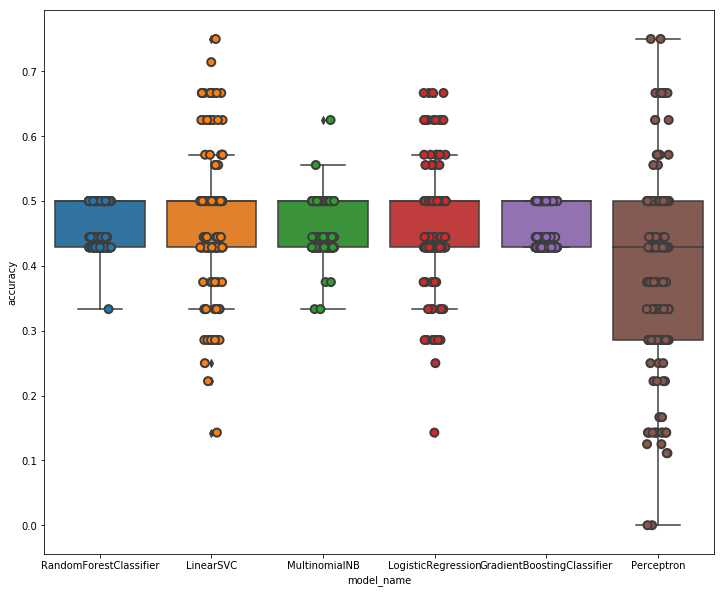

La presición de los modelos es: 
 model_name
GradientBoostingClassifier    0.467183
LinearSVC                     0.469514
LogisticRegression            0.469067
MultinomialNB                 0.466002
Perceptron                    0.401210
RandomForestClassifier        0.466627
Name: accuracy, dtype: float64


In [28]:
# Importar librerías
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import ensemble
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

# Dividir la data en predictoras y target
dataf = dataset2
X1 = dataf.iloc[:,1:dataf.shape[1]-1]
# Escalar las variables predictoras
sc = MinMaxScaler()
sc.fit(X1)
X = pd.DataFrame(sc.transform(X1), columns=X1.columns).values
# Seleccionar la variable target
y = dataf['target'].values

# Dividir la data en entrenamiento y prueba
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.3, random_state = 29)

a= [X_train, X_test]
for i in a:
    print(i.shape)


# Modelado de la data utilizando Cross validation
params = {'n_estimators': 4
          , 'max_depth': 3, 'subsample': 0.6,
          'learning_rate': 0.005, 'min_samples_leaf': 2, 'random_state': 29}

models = [
    RandomForestClassifier(n_estimators=4, max_depth = 1, random_state = 29, min_samples_split=2, min_samples_leaf=17),
    LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    ensemble.GradientBoostingClassifier(**params), 
    Perceptron(n_iter=40, eta0=0.01, random_state=0),
]
CV = 200
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
#plt.title('Distribución de la presición global para los modelos probados')
plt.show()

print('La presición de los modelos es: \n', cv_df.groupby('model_name').accuracy.mean())